# **Ensamble Strategies**

![Averaging Algorithms](resources/Averaging%20algorithms.png)

In [14]:
import pickle

# cargar el conjunto de datos  Forest covertypes
covertype_dataset = pickle.load(open("resources/covertype_dataset.pickle", "rb"))

print(covertype_dataset.DESCR)
covertype_X = covertype_dataset.data[:15000, :]
covertype_y = covertype_dataset.target[:15000]
covertypes = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine',
              'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']


.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional a

## Example of Bagging
Los **modelos débiles(weak)** son una buena elección para el estimador que se
utilizará con **bagging**. Un aprendiz débil en clasificación o predicción es
simplemente un algoritmo que funciona solo por encima de la línea dee azar  debido a su simplicidad o alto
sesgo en la estimación. Algunos buenos ejemplos son Naive Bayes y K
Nearest Neighbors.

 La ventaja de utilizar aprendices débiles y ensamblarlos es que se pueden entrenar
más rápidamente que los algoritmos complejos y  aunque su capacidad de  predicción es débil, cuando se combinan, suelen lograr resultados de predicción razonables

In [5]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

hypothesis = BaggingClassifier(KNeighborsClassifier(n_neighbors=1),
                               max_samples=0.7, max_features=0.7,
                               n_estimators=100)
scores = cross_val_score(hypothesis, covertype_X, covertype_y, cv=3,
                         scoring='accuracy', n_jobs=-1)
print("BaggingClassifier -> cross validation accuracy: mean=% 0.3f std= % 0.3f" %
      (np.mean(scores), np.std(scores)))


BaggingClassifier -> cross validation accuracy: mean= 0.793 std=  0.007


Similar a este ejemplo, podemos realizar los 4 algoritmos de **Averaging**. Y para ajustar los hiperparámetros se puede probar con GridSearchCV(). Según nuestra experiencia, si necesita limitar o acelerar la búsqueda, los valores que mejor funcionan con más frecuencia están entre 0,7 y 0,9.

## RandonForest vs Extra-Trees

Veamos cómo se comparan los dos algoritmos con el problema Covertype-forest, tanto en términos de precisión de la predicción como de tiempo de ejecución.Recordar que la principal diferencia que tienen los dos es que una vez que selecioanron un subconjunto aleatorio de caracarteristicas como candidadtas para realizar la division en un nodo  **RandomForest** selecciona la optima de acuerdo a una métrica; mientras que **ExtraTrees** la selecciona aleatoriamente

In [6]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


In [7]:
%%time
hypothesis = RandomForestClassifier(n_estimators=100, random_state=101)
scores = cross_val_score(hypothesis, covertype_X, covertype_y,
                         cv=3, scoring='accuracy', n_jobs=-1)
print(hypothesis,"RandomForestClassifier -> cross validation accuracy: \mean = %0.3f std = %0.3f" %
      (np.mean(scores), np.std(scores)))


RandomForestClassifier(random_state=101) RandomForestClassifier -> cross validation accuracy: \mean = 0.811 std = 0.006
CPU times: total: 78.1 ms
Wall time: 3.53 s


In [8]:
%%time
hypothesis = ExtraTreesClassifier(n_estimators=100, random_state=101)
scores = cross_val_score(hypothesis, covertype_X, covertype_y, cv=3,
                         scoring='accuracy', n_jobs=-1)
print("ExtraTreesClassifier -> cross validation accuracy: mean=% 0.3f       std= % 0.3f" %
      (np.mean(scores), np.std(scores)))


ExtraTreesClassifier -> cross validation accuracy: mean= 0.822       std=  0.006
CPU times: total: 31.2 ms
Wall time: 3.29 s


Los principales hiperparamétros son : 
* **max_features**: Es el número de características muestreadas presentes en cada división que pueden determinar el rendimiento del algoritmo. Cuanto menor sea el número, más rápido, pero con mayor sesgo.
* **min_samples_leaf**: Permite determinar la profundidad de los árboles. Los números grandes disminuyen la varianza y aumentan el sesgo.
* **bootstrap**: This is a Boolean that allows bootstrapping.
* **n_estimators**: : Este es el número de árboles (recuerde que cuantos más
árboles mejor, pero esto tiene un coste computacional 

In [9]:
# ejemplo de regression

import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.preprocessing import scale

X_train, y_train = pickle.load(open("resources/cadata.pickle", "rb"))
first_rows = 2000

X_train = scale(X_train[:first_rows, :].toarray())
y_train = y_train[:first_rows]/10**4.

hypothesis = RandomForestRegressor(n_estimators=300, random_state=101)
scores = cross_val_score(hypothesis, X_train, y_train, cv=3,
                         scoring='neg_mean_absolute_error', n_jobs=-1)
print("RandomForestRegessor -> cross validation accuracy: mean=% 0.3f       std=% 0.3f" %
      (np.mean(scores), np.std(scores)))


RandomForestRegessor -> cross validation accuracy: mean=-4.664       std= 0.505


## Estimacion de Probabilidades con **CalibratedClassiferCV**

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

hypothesis = RandomForestClassifier(n_estimators=100, random_state=101)
calibration = CalibratedClassifierCV(hypothesis, method='sigmoid', cv=5)
covertype_X = covertype_dataset.data[:15000,:]
covertype_y = covertype_dataset.target[:15000]
covertype_test_X = covertype_dataset.data[15000:25000,:]
covertype_test_y = covertype_dataset.target[15000:25000]

In [11]:
hypothesis.fit(covertype_X, covertype_y)
calibration.fit(covertype_X, covertype_y)

# probabilidades del RandomForest en bruto
prob_raw = hypothesis.predict_proba(covertype_test_X)


# calibramos las estimamos de las probabilidades,
prob_cal = calibration.predict_proba(covertype_test_X)
print(prob_raw[:1, :])
print(prob_cal[:1, :])
covertype_test_y[0]


[[0.   0.03 0.87 0.06 0.   0.04 0.  ]]
[[0.01907878 0.02393735 0.92994385 0.0048556  0.00474467 0.01391278
  0.00352698]]


3

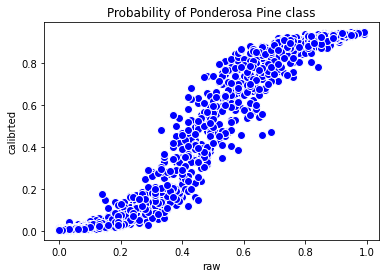

In [12]:
# %matplotlib inline

# tomar una clase como ejemlo apra comparar las prob. en bruto con las calibradas
tree_kind = covertypes.index('Ponderosa Pine')
probs = pd.DataFrame(list(zip(prob_raw[:, tree_kind],
                              prob_cal[:, tree_kind])),
                     columns=['raw', 'calibrted'])
plot = probs.plot(kind='scatter', x=0, y=1, s=64,
                  c='blue', edgecolors='white', title='Probability of Ponderosa Pine class')


La calibración, aunque no modifica el rendimiento del modelo, al
remodelar la salida de probabilidad le ayuda a obtener probabilidades que
se correspondan mejor con los datos de entrenamiento. En el 
gráfico se puede observar cómo el procedimiento de calibración ha
modificado las probabilidades originales añadiendo cierta no linealidad
como corrección:

## **Boostig Algorithms**

### ADA-Boost

In [21]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
hypothesis = AdaBoostClassifier(n_estimators=300, random_state=101)
scores = cross_val_score(hypothesis, covertype_X, covertype_y, cv=3,
                         scoring='accuracy', n_jobs=-1)
print("Adaboost -> cross validation accuracy: mean = %0.3f std = %0.3f" %
      (np.mean(scores), np.std(scores)))


Adaboost -> cross validation accuracy: mean = 0.622 std = 0.006


### Gradient tree boosting (GTB)

In [20]:
# intentaremos  mejorar nuestro rendimiento predictivo en el conjunto de datos  covertype, que ya 
# se examinó al ilustrar los algoritmos SVM lineal 
import pickle
covertype_dataset = pickle.load(open("resources/covertype_dataset.pickle", "rb"))
covertype_X = covertype_dataset.data[:15000,:]
covertype_y = covertype_dataset.target[:15000] -1 
covertype_val_X = covertype_dataset.data[15000:20000,:]
covertype_val_y = covertype_dataset.target[15000:20000] -1
covertype_test_X = covertype_dataset.data[20000:25000,:]
covertype_test_y = covertype_dataset.target[20000:25000] -1

In [24]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

hypothesis = GradientBoostingClassifier(max_depth=5, n_estimators=60, random_state=101)
hypothesis.fit(covertype_X, covertype_y)

print("GradientBoostingClassifier -> test accuracy:",
      accuracy_score(covertype_test_y, hypothesis.predict(covertype_test_X)))


GradientBoostingClassifier -> test accuracy: 0.7856


La precisión resultante es 0.78 , que es mucho mejor que la obtenida utilizando por **LinearSVC**. Podriamos obtener un mejor rendimiento ajustando los siguientes parametros: 
 
* **n_estimators**: Si se excede con los estimadores, aumenta la varianza. De todos modos, si
los estimadores no son suficientes, el algoritmo sufrirá un alto sesgo. El número correcto no
puede conocerse a priori, sino que debe hallarse de forma heurística, probando varias configuraciones mediante validación cruzada
 
* **max_depth**: aumentarla incrementara la varianza y la complejidad 
 
* **subsample**:  Puede reducir eficazmente la varianza de las estimaciones utilizando valores de 0,9 a 0,7.
 
* **learning_rate**: Valores más pequeños pueden mejorar la
optimización en el proceso de entrenamiento, aunque eso
requerirá más estimadores para converger, y por lo tanto más
tiempo computacional.
 
* **in_samples_leaf**: Esto puede reducir la varianza debida a datos ruidosos, reservando el sobreajuste a casos raros.
